# Importing dependencies

In [41]:
import os
import requests
import zipfile
import io
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.ensemble import RandomForestClassifier


#### Importing dataset

In [2]:
# Define the URL and file paths
url = "https://github.com/Technocolabs100/Mortgage-Prepayment-Analysis-and-Prediction/archive/refs/heads/main.zip"
extracted_dir = "dataset"
csv_file_path = os.path.join(extracted_dir, "LoanExport.csv")

# Check if the CSV file already exists
if os.path.exists(csv_file_path):
    print(f"[INFO] The file '{csv_file_path}' already exists. No download needed.")
else:
    print(f"[INFO] File not found. Downloading the ZIP file...")
    response = requests.get(url, stream=True)
    if response.status_code == 200:
        with zipfile.ZipFile(io.BytesIO(response.content)) as zip_ref:
            zip_ref.extractall(extracted_dir)
        print(f"[INFO] The file has been downloaded and extracted to the '{extracted_dir}' directory.")
    else:
        print(f"[ERROR] Failed to download the file. Status code: {response.status_code}")

# Load the CSV file into a DataFrame
data = pd.read_csv(csv_file_path)

# Display the first few rows of the DataFrame
print(data.head())

[INFO] The file 'dataset\LoanExport.csv' already exists. No download needed.
   CreditScore  FirstPaymentDate FirstTimeHomebuyer  MaturityDate    MSA  MIP  \
0            0            199902                  N        202901  16974   25   
1            0            199902                  N        202901  19740    0   
2            0            199902                  N        202901  29940    0   
3            0            199902                  N        202901  31084    0   
4            0            199902                  N        202901  35644    0   

   Units Occupancy  OCLTV  DTI  ...  PostalCode    LoanSeqNum  LoanPurpose  \
0      1         O     89   27  ...       60400  F199Q1268030            P   
1      1         O     73   17  ...       80200  F199Q1015092            N   
2      1         O     75   16  ...       66000  F199Q1266886            N   
3      1         O     76   14  ...       90700  F199Q1178167            N   
4      1         O     78   18  ...        760

C:\Users\user\AppData\Local\Temp\ipykernel_14120\2125035767.py:20: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(csv_file_path)


## Exploratory Data Analysis (EDA)

In [3]:
data.head(5)

CreditScore  FirstPaymentDate FirstTimeHomebuyer  MaturityDate    MSA  MIP  \
0            0            199902                  N        202901  16974   25   
1            0            199902                  N        202901  19740    0   
2            0            199902                  N        202901  29940    0   
3            0            199902                  N        202901  31084    0   
4            0            199902                  N        202901  35644    0   

   Units Occupancy  OCLTV  DTI  ...  PostalCode    LoanSeqNum  LoanPurpose  \
0      1         O     89   27  ...       60400  F199Q1268030            P   
1      1         O     73   17  ...       80200  F199Q1015092            N   
2      1         O     75   16  ...       66000  F199Q1266886            N   
3      1         O     76   14  ...       90700  F199Q1178167            N   
4      1         O     78   18  ...        7600  F199Q1178517            N   

  OrigLoanTerm NumBorrowers SellerName          ServicerName EverDelinquent  \
0          360            2         FL  WASHINGTONMUTUALBANK              0   
1          360            1         FT  CHASEHOMEFINANCELLC               0   
2          360            2         FL  WASHINGTONMUTUALBANK              0   
3          360            2         GM  GMACMTGECORP                      0   
4          360            2         GM  GMACMTGECORP                      0   

  MonthsDelinquent MonthsInRepayment  
0                0                52  
1                0               144  
2                0                67  
3                0                35  
4                0                54  

[5 rows x 28 columns]

In [4]:
data.columns

Index(['CreditScore', 'FirstPaymentDate', 'FirstTimeHomebuyer', 'MaturityDate',
       'MSA', 'MIP', 'Units', 'Occupancy', 'OCLTV', 'DTI', 'OrigUPB', 'LTV',
       'OrigInterestRate', 'Channel', 'PPM', 'ProductType', 'PropertyState',
       'PropertyType', 'PostalCode', 'LoanSeqNum', 'LoanPurpose',
       'OrigLoanTerm', 'NumBorrowers', 'SellerName', 'ServicerName',
       'EverDelinquent', 'MonthsDelinquent', 'MonthsInRepayment'],
      dtype='object')

In [5]:
print("Shape of the Data:", data.shape)
print("Data Types and Null Counts:\n", data.info())

Shape of the Data: (291451, 28)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 291451 entries, 0 to 291450
Data columns (total 28 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   CreditScore         291451 non-null  int64  
 1   FirstPaymentDate    291451 non-null  int64  
 2   FirstTimeHomebuyer  291451 non-null  object 
 3   MaturityDate        291451 non-null  int64  
 4   MSA                 291451 non-null  object 
 5   MIP                 291451 non-null  int64  
 6   Units               291451 non-null  int64  
 7   Occupancy           291451 non-null  object 
 8   OCLTV               291451 non-null  int64  
 9   DTI                 291451 non-null  int64  
 10  OrigUPB             291451 non-null  int64  
 11  LTV                 291451 non-null  int64  
 12  OrigInterestRate    291451 non-null  float64
 13  Channel             291451 non-null  object 
 14  PPM                 291451 non-null  object 
 15  Pr

In [6]:
print(data.describe(include='all').round(2))

        CreditScore  FirstPaymentDate FirstTimeHomebuyer  MaturityDate  \
count     291451.00         291451.00             291451     291451.00   
unique          NaN               NaN                  3           NaN   
top             NaN               NaN                  N           NaN   
freq            NaN               NaN             184154           NaN   
mean         708.94         199904.76                NaN     202902.37   
std           68.41             13.82                NaN         16.09   
min            0.00         199901.00                NaN     202402.00   
25%          675.00         199903.00                NaN     202902.00   
50%          717.00         199904.00                NaN     202903.00   
75%          753.00         199905.00                NaN     202904.00   
max          849.00         201303.00                NaN     204302.00   

           MSA        MIP      Units Occupancy      OCLTV        DTI  ...  \
count   291451  291451.00  291451.

In [7]:
data.isnull().sum()

CreditScore               0
FirstPaymentDate          0
FirstTimeHomebuyer        0
MaturityDate              0
MSA                       0
MIP                       0
Units                     0
Occupancy                 0
OCLTV                     0
DTI                       0
OrigUPB                   0
LTV                       0
OrigInterestRate          0
Channel                   0
PPM                       0
ProductType               0
PropertyState             0
PropertyType              0
PostalCode                0
LoanSeqNum                0
LoanPurpose               0
OrigLoanTerm              0
NumBorrowers              0
SellerName            24994
ServicerName              0
EverDelinquent            0
MonthsDelinquent          0
MonthsInRepayment         0
dtype: int64

So only in Seller name has null values 

In [8]:
data.SellerName[data['SellerName'].isnull()]

32        NaN
37        NaN
38        NaN
40        NaN
44        NaN
         ... 
291359    NaN
291374    NaN
291384    NaN
291403    NaN
291415    NaN
Name: SellerName, Length: 24994, dtype: object

In [9]:
print(f'Total null values of Seller Name column are : {data.SellerName.isnull().sum()}')
print(f'Total not null values of Seller Name column are : {data.SellerName.notnull().sum()}')

Total null values of Seller Name column are : 24994
Total not null values of Seller Name column are : 266457


In [10]:
data.SellerName.unique()

array(['FL', 'FT', 'GM', 'Ot', 'RE', 'NO', 'ST', 'CR', 'CH', 'FI', 'HO',
       'PR', nan, 'PN', 'WA', 'BA', 'G ', 'OL', 'AC', 'CO', 'BI'],
      dtype=object)

So from above we can say either we can remove the whole column or we can change it with mode values of all 

In [11]:
# Unique values of postal codes'
len(data['PostalCode'].unique())

1767

In [12]:
# Checking duplicates values
data.duplicated().sum()

0

No duplicate values

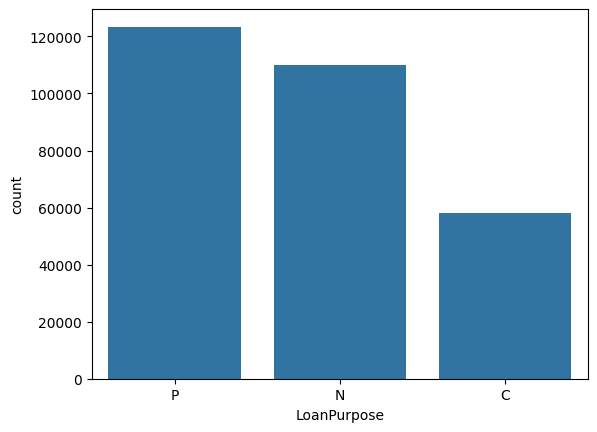

In [13]:
sns.countplot(x='LoanPurpose', data=data)
plt.show()

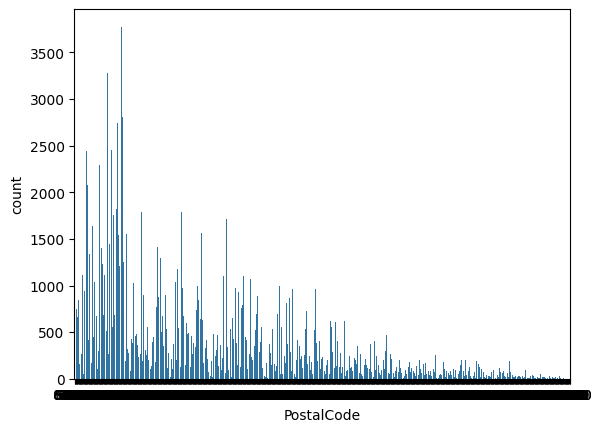

In [14]:
sns.countplot(x='PostalCode', data=data)
plt.show()

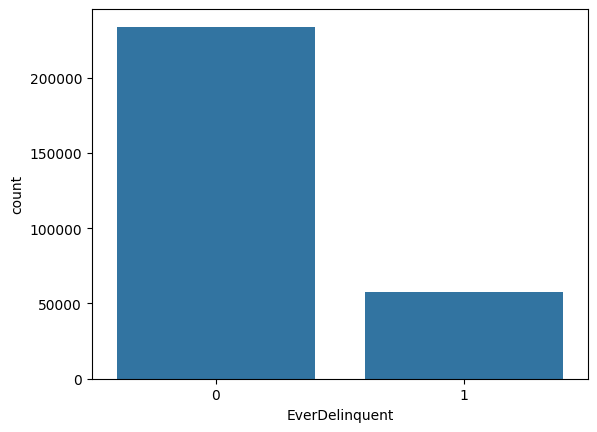

In [15]:
sns.countplot(x='EverDelinquent', data=data)
plt.show()

## Data Cleaning

##### Handling missing values

In [16]:
data['SellerName'] = data['SellerName'].mode()[0]

I used mode because the values are in catagorical type

In [17]:
data.dtypes

CreditScore             int64
FirstPaymentDate        int64
FirstTimeHomebuyer     object
MaturityDate            int64
MSA                    object
MIP                     int64
Units                   int64
Occupancy              object
OCLTV                   int64
DTI                     int64
OrigUPB                 int64
LTV                     int64
OrigInterestRate      float64
Channel                object
PPM                    object
ProductType            object
PropertyState          object
PropertyType           object
PostalCode             object
LoanSeqNum             object
LoanPurpose            object
OrigLoanTerm            int64
NumBorrowers           object
SellerName             object
ServicerName           object
EverDelinquent          int64
MonthsDelinquent        int64
MonthsInRepayment       int64
dtype: object

##### Correcting data types
Formatting Date

In [18]:
data['FirstPaymentDate'] = pd.to_datetime(data['FirstPaymentDate'], format='%Y%m')
data['MaturityDate'] = pd.to_datetime(data['MaturityDate'], format='%Y%m')

In [19]:
categorical_columns = ['FirstTimeHomebuyer', 'Occupancy', 'ProductType', 'PropertyState', 'PropertyType', 'LoanPurpose', 'SellerName', 'ServicerName','NumBorrowers','PPM','Channel']
for items in categorical_columns:
    if items in data.columns:
        print(f'{items} : {data[items].unique()}')
    else:
        print(f'Column {items} is not available in the dataset.')

FirstTimeHomebuyer : ['N' 'X' 'Y']
Occupancy : ['O' 'I' 'S']
ProductType : ['FRM  ']
PropertyState : ['IL' 'CO' 'KS' 'CA' 'NJ' 'WI' 'FL' 'CT' 'GA' 'TX' 'MD' 'MA' 'SC' 'WY'
 'NC' 'AZ' 'IN' 'MS' 'NY' 'WA' 'AR' 'VA' 'MN' 'LA' 'PA' 'OR' 'RI' 'UT'
 'MI' 'TN' 'AL' 'MO' 'IA' 'NM' 'NV' 'VT' 'OH' 'NE' 'HI' 'ID' 'PR' 'DC'
 'GU' 'KY' 'NH' 'SD' 'ME' 'MT' 'OK' 'WV' 'DE' 'ND' 'AK']
PropertyType : ['SF' 'PU' 'CO' 'MH' 'CP' 'LH' 'X ']
LoanPurpose : ['P' 'N' 'C']
SellerName : ['Ot']
ServicerName : ['WASHINGTONMUTUALBANK' 'CHASEHOMEFINANCELLC ' 'GMACMTGECORP        '
 'Other servicers     ' 'WELLSFARGOBANKNA   ' 'ABNAMROMTGEGROUPINC'
 'BANKOFAMERICANA    ' 'CHASEMANHATTANMTGECO' 'HOMESIDELENDINGINC '
 'CHASEMTGECO         ' 'WELLSFARGOHOMEMORTGA' 'PRINCIPALRESIDENTIAL'
 'CITIMORTGAGEINC    ' 'JPMORGANCHASEBANKNA' 'BAMORTGAGELLC      '
 'NATLCITYMTGECO      ' 'FTMTGESERVICESINC  ' 'SUNTRUSTMORTGAGEINC'
 'COUNTRYWIDE         ' 'FIFTHTHIRDBANK      ']
NumBorrowers : ['2' '1' 'X ']
PPM : ['N' 'X' 'Y']
Chann

In [20]:
x_count = data['MSA'].value_counts().get('X    ', 0)
print(f"Number of values in MSA column with 'X    ': {x_count}")

data['MSA'] = data['MSA'].str.strip()
data['MSA'] = pd.to_numeric(data['MSA'], errors='coerce')
data['MSA'].fillna(data['MSA'].mode().iloc[0], inplace=True)

Number of values in MSA column with 'X    ': 39100


In [21]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
for items in categorical_columns:
    data[items] = le.fit_transform(data[items])

In [22]:
data.dtypes

CreditScore                    int64
FirstPaymentDate      datetime64[ns]
FirstTimeHomebuyer             int32
MaturityDate          datetime64[ns]
MSA                          float64
MIP                            int64
Units                          int64
Occupancy                      int32
OCLTV                          int64
DTI                            int64
OrigUPB                        int64
LTV                            int64
OrigInterestRate             float64
Channel                        int32
PPM                            int32
ProductType                    int32
PropertyState                  int32
PropertyType                   int32
PostalCode                    object
LoanSeqNum                    object
LoanPurpose                    int32
OrigLoanTerm                   int64
NumBorrowers                   int32
SellerName                     int32
ServicerName                   int32
EverDelinquent                 int64
MonthsDelinquent               int64
M

In [ ]:
corr = data.drop(columns=['PostalCode','LoanSeqNum','FirstPaymentDate','MaturityDate'])

plt.figure(figsize=(20, 15))  
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)

plt.title('Correlation Heatmap')
plt.show()

KeyboardInterrupt: 

## Model Building

so *seller name* and *product type* is useless as it has same values so dropping will be better option

In [24]:
data.drop(columns=['ProductType','SellerName','LoanSeqNum','PostalCode'],inplace=True)

In [25]:
# Feature engineering
data['LoanTermRemaining'] = data['MaturityDate'].dt.year - data['FirstPaymentDate'].dt.year

In [26]:
data

CreditScore FirstPaymentDate  FirstTimeHomebuyer MaturityDate  \
0                 0       1999-02-01                   0   2029-01-01   
1                 0       1999-02-01                   0   2029-01-01   
2                 0       1999-02-01                   0   2029-01-01   
3                 0       1999-02-01                   0   2029-01-01   
4                 0       1999-02-01                   0   2029-01-01   
...             ...              ...                 ...          ...   
291446          839       1999-03-01                   0   2029-02-01   
291447          840       2002-10-01                   0   2029-04-01   
291448          840       2003-04-01                   0   2029-04-01   
291449          845       1999-04-01                   0   2029-03-01   
291450          849       1999-03-01                   0   2029-02-01   

            MSA  MIP  Units  Occupancy  OCLTV  DTI  ...  PropertyState  \
0       16974.0   25      1          1     89   27  ...             15   
1       19740.0    0      1          1     73   17  ...              5   
2       29940.0    0      1          1     75   16  ...             17   
3       31084.0    0      1          1     76   14  ...              4   
4       35644.0    0      1          1     78   18  ...             32   
...         ...  ...    ...        ...    ...  ...  ...            ...   
291446  37964.0    0      1          1     60   32  ...             39   
291447  35644.0    0      1          1     73    0  ...             35   
291448  42044.0    0      1          1     73   31  ...              4   
291449  37964.0    0      1          0     80   54  ...             39   
291450  37964.0    0      1          1     47   29  ...             39   

        PropertyType  LoanPurpose  OrigLoanTerm  NumBorrowers  ServicerName  \
0                  5            2           360             1            17   
1                  5            1           360             0             3   
2                  5            1           360             1            17   
3                  5            1           360             1            10   
4                  5            1           360             1            10   
...              ...          ...           ...           ...           ...   
291446             5            1           360             1            14   
291447             5            2           319             1            14   
291448             5            1           313             0            14   
291449             5            2           360             1            14   
291450             5            2           360             1            14   

        EverDelinquent  MonthsDelinquent  MonthsInRepayment  LoanTermRemaining  
0                    0                 0                 52                 30  
1                    0                 0                144                 30  
2                    0                 0                 67                 30  
3                    0                 0                 35                 30  
4                    0                 0                 54                 30  
...                ...               ...                ...                ...  
291446               0                 0                 12                 30  
291447               0                 0                 53                 27  
291448               0                 0                 38                 26  
291449               0                 0                 32                 30  
291450               0                 0                 29                 30  

[291451 rows x 25 columns]

### Feature selection

In [29]:
X = data.drop(columns=['EverDelinquent','FirstPaymentDate','MaturityDate'])
y = data.EverDelinquent

In [32]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [33]:
model = LogisticRegression(max_iter=1000)

rfe = RFE(model, n_features_to_select=10)

fit = rfe.fit(X_scaled, y)

print("Selected Features:", fit.support_)


#df.to_csv('cleaned_data.csv', index=False)


Selected Features: [ True False False False False False  True  True False  True  True  True
 False False False  True False  True False  True  True False]


In [34]:
feature_names = X.columns.tolist()  
selected_features = [name for name, selected in zip(feature_names, fit.support_) if selected]
print("Selected Features:", selected_features)

Selected Features: ['CreditScore', 'OCLTV', 'DTI', 'LTV', 'OrigInterestRate', 'Channel', 'LoanPurpose', 'NumBorrowers', 'MonthsDelinquent', 'MonthsInRepayment']


##### Splitting data 

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X[selected_features], y, test_size=0.3, random_state=42)

#### Logistic Regression

In [35]:
model = LogisticRegression(max_iter=1000)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

In [40]:
conf_matrix = confusion_matrix(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print("Confusion Matrix:")
print(conf_matrix)
print("\nAccuracy Score:", accuracy)
print("\nClassification Report:")
print(class_report)

Confusion Matrix:
[[70135     0]
 [    0 17301]]

Accuracy Score: 1.0

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     70135
           1       1.00      1.00      1.00     17301

    accuracy                           1.00     87436
   macro avg       1.00      1.00      1.00     87436
weighted avg       1.00      1.00      1.00     87436



#### Random Forest Classifier

In [42]:
rf_model = RandomForestClassifier(random_state=42)

rf_model.fit(X_train, y_train)

y_pred_rf = rf_model.predict(X_test)

# Evaluate the model
conf_matrix_rf = confusion_matrix(y_test, y_pred_rf)
accuracy_rf = accuracy_score(y_test, y_pred_rf)
class_report_rf = classification_report(y_test, y_pred_rf)

print("Confusion Matrix (Random Forest):")
print(conf_matrix_rf)
print("\nAccuracy Score (Random Forest):", accuracy_rf)
print("\nClassification Report (Random Forest):")
print(class_report_rf)


Confusion Matrix (Random Forest):
[[70135     0]
 [    0 17301]]

Accuracy Score (Random Forest): 1.0

Classification Report (Random Forest):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     70135
           1       1.00      1.00      1.00     17301

    accuracy                           1.00     87436
   macro avg       1.00      1.00      1.00     87436
weighted avg       1.00      1.00      1.00     87436



In [43]:
classifiers = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(random_state=42),
    
}

for name, clf in classifiers.items():
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"{name} Accuracy: {accuracy}")
    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred))
    print("-" * 60)


Logistic Regression Accuracy: 1.0
[[70135     0]
 [    0 17301]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     70135
           1       1.00      1.00      1.00     17301

    accuracy                           1.00     87436
   macro avg       1.00      1.00      1.00     87436
weighted avg       1.00      1.00      1.00     87436

------------------------------------------------------------
Random Forest Accuracy: 1.0
[[70135     0]
 [    0 17301]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     70135
           1       1.00      1.00      1.00     17301

    accuracy                           1.00     87436
   macro avg       1.00      1.00      1.00     87436
weighted avg       1.00      1.00      1.00     87436

------------------------------------------------------------


In [44]:
from sklearn.model_selection import cross_val_score

# Perform cross-validation for Logistic Regression
cv_scores_log = cross_val_score(model, X[selected_features], y, cv=5)
print("Logistic Regression Cross-Validation Scores:", cv_scores_log)
print("Average CV Score:", cv_scores_log.mean())

# Perform cross-validation for Random Forest
cv_scores_rf = cross_val_score(rf_model, X[selected_features], y, cv=5)
print("Random Forest Cross-Validation Scores:", cv_scores_rf)
print("Average CV Score:", cv_scores_rf.mean())


Logistic Regression Cross-Validation Scores: [0.98516066 1.         1.         1.         1.        ]
Average CV Score: 0.9970321318900002
Random Forest Cross-Validation Scores: [1. 1. 1. 1. 1.]
Average CV Score: 1.0


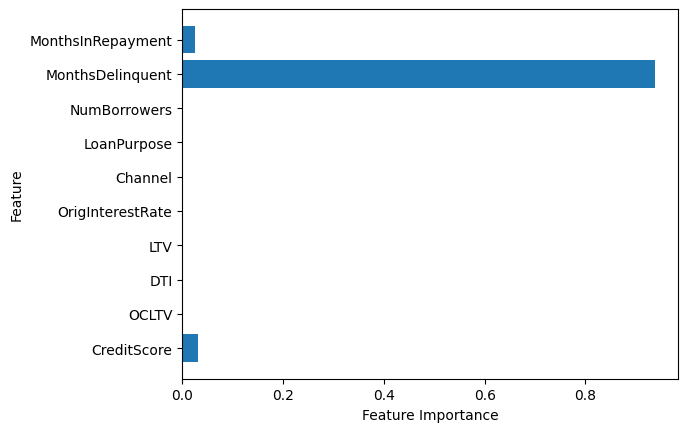

In [45]:
import matplotlib.pyplot as plt

feature_importances = rf_model.feature_importances_
plt.barh(selected_features, feature_importances)
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.show()


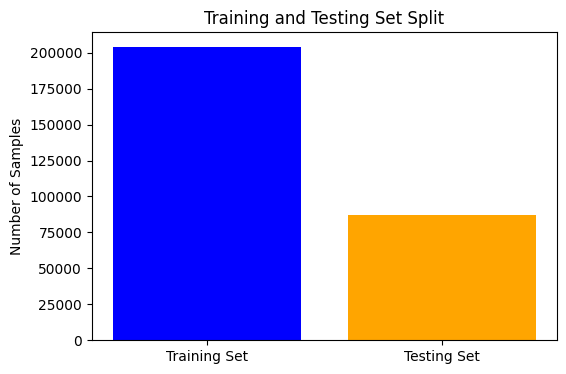

In [47]:
plt.figure(figsize=(6, 4))
plt.bar(['Training Set', 'Testing Set'], [len(X_train), len(X_test)], color=['blue', 'orange'])
plt.ylabel('Number of Samples')
plt.title('Training and Testing Set Split')
plt.show()